# Preparation

In [1]:
#Git Repo Hammam Tugas Akhir
import csv
import regex
import datetime as dt
from datetime import timedelta
import locale
locale.setlocale(locale.LC_TIME, 'id-ID.UTF-8')

import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as snsc

import warnings
warnings.filterwarnings("ignore")
#from feature_engine.outlier_removers import Winsorizer

## Import dataset

In [2]:
df = pd.read_csv("Coret-Coret Marketing_Transaction Details (TA Hammam)_2006-2105.csv")
# df = pd.read_csv("Coret-Coret Marketing_Transaction Details (TA Hammam)_2003-2105.csv")
# df = pd.read_csv("Coret-Coret Marketing_Transaction Details (TA Hammam)_1904-2104.csv")
display(df.info())
df.to_csv("Hasil/Data_TA.csv")
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52395 entries, 0 to 52394
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   delivery_date     52395 non-null  object 
 1   delivery_status   52395 non-null  object 
 2   no_order          52395 non-null  object 
 3   Channel           52395 non-null  object 
 4   transaction_type  52395 non-null  object 
 5   ID CL             30802 non-null  float64
 6   nama_komunitas    28003 non-null  object 
 7   name              52395 non-null  object 
 8   username          52380 non-null  object 
 9   useremail         52380 non-null  object 
 10  telp              52319 non-null  object 
 11  prod_id           51655 non-null  float64
 12  produk            51655 non-null  object 
 13  harga             52395 non-null  float64
 14  qty               52395 non-null  float64
 15  subtotal          52395 non-null  float64
dtypes: float64(5), object(11)
memory usage: 

None

,delivery_date,delivery_status,no_order,Channel,transaction_type,ID CL,nama_komunitas,name,username,useremail,telp,prod_id,produk,harga,qty,subtotal
0,1 Jun 2020,delivered,54SSWRQQQ247,CL,normal,36.0,CL09 Bu agustin,CL09 Bu Agustin,Zakia Puspa Ramdhani,zakiapuspa24@gmail.com,087800014499,180.0,DAGING AYAM KARKAS 700GR,25000.0,3.0,75000.0
1,1 Jun 2020,delivered,54SSWRQQQ247,CL,normal,36.0,CL09 Bu agustin,CL09 Bu Agustin,Zakia Puspa Ramdhani,zakiapuspa24@gmail.com,087800014499,166.0,DAGING AYAM CEKER KG,25000.0,2.0,50000.0
2,2 Jun 2020,delivered,54SSWSQQQ060,CL,normal,6.0,NaN,CL38 Roma Suci,Zakia Puspa Ramdhani,zakiapuspa24@gmail.com,087800014499,237.0,GREENFIELD UHT CHOCOMALT 250ML,7000.0,2.0,14000.0
3,2 Jun 2020,delivered,54SSWSQQQ060,CL,normal,6.0,NaN,CL38 Roma Suci,Zakia Puspa Ramdhani,zakiapuspa24@gmail.com,087800014499,180.0,DAGING AYAM KARKAS 700GR,25000.0,3.0,75000.0
4,2 Jun 2020,delivered,54SSWSQQQ060,CL,normal,6.0,NaN,CL38 Roma Suci,Zakia Puspa Ramdhani,zakiapuspa24@gmail.com,087800014499,166.0,DAGING AYAM CEKER KG,25000.0,2.0,50000.0
5,2 Jun 2020,delivered,56SSWRQQQ053,CL,normal,12.0,CL15 Bu Mikail,CL15 Bu Mikail,Ternakfresh Indonesia,ternakmart@gmail.com,081381306699,169.0,DAGING AYAM KARKAS 1KG PARTING 12,35000.0,1.0,35000.0
6,2 Jun 2020,delivered,56SSWRQQQ053,CL,normal,12.0,CL15 Bu Mikail,CL15 Bu Mikail,Ternakfresh Indonesia,ternakmart@gmail.com,081381306699,225.0,DAGING SAPI GILING 500GR,62000.0,1.0,62000.0
7,2 Jun 2020,delivered,56SSWRQQQ0X0,CL,normal,11.0,CL27 Bu Intan,CL27 Bu Intan,Ternakfresh Indonesia,ternakmart@gmail.com,0895345368597,210.0,DAGING SAPI BUNTUT SPECIAL KG,99000.0,1.0,99000.0
8,2 Jun 2020,delivered,56SSWRQQQ0X0,CL,normal,11.0,CL27 Bu Intan,CL27 Bu Intan,Ternakfresh Indonesia,ternakmart@gmail.com,0895345368597,240.0,GREENFIELD UHT CHOCOMALT 1000ML,22000.0,1.0,22000.0
9,2 Jun 2020,delivered,56SSWRQQQ0X0,CL,normal,11.0,CL27 Bu Intan,CL27 Bu Intan,Ternakfresh Indonesia,ternakmart@gmail.com,0895345368597,225.0,DAGING SAPI GILING 500GR,62000.0,2.0,124000.0


In [3]:
print("Dataset dimension : " + str(df.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df['no_order']))))

Dataset dimension : (52395, 16)
Jumlah Customer : 3641
Jumlah Transaksi : 20469


# Cleaning

In [4]:
#Clean unused atribute
df.drop(['transaction_type', 'ID CL', 'nama_komunitas', 'username', 'useremail', 'prod_id', 'harga', 'qty'],axis=1)

,delivery_date,delivery_status,no_order,Channel,name,telp,produk,subtotal
0,1 Jun 2020,delivered,54SSWRQQQ247,CL,CL09 Bu Agustin,087800014499,DAGING AYAM KARKAS 700GR,75000.0
1,1 Jun 2020,delivered,54SSWRQQQ247,CL,CL09 Bu Agustin,087800014499,DAGING AYAM CEKER KG,50000.0
2,2 Jun 2020,delivered,54SSWSQQQ060,CL,CL38 Roma Suci,087800014499,GREENFIELD UHT CHOCOMALT 250ML,14000.0
3,2 Jun 2020,delivered,54SSWSQQQ060,CL,CL38 Roma Suci,087800014499,DAGING AYAM KARKAS 700GR,75000.0
4,2 Jun 2020,delivered,54SSWSQQQ060,CL,CL38 Roma Suci,087800014499,DAGING AYAM CEKER KG,50000.0
...,...,...,...,...,...,...,...,...
52390,31 Mei 2021,delivered,INV21053100204ZRTX,Outlet,Nanang Arief Pambudhi,089509417907,CIMORY UHT MILK MATCHA 250ML,6500.0
52391,31 Mei 2021,delivered,INV21053100207IHPI,Outlet,Nanang Arief Pambudhi,089509417907,WALLS MAGNUM WHITE ALMOND 80ML,13000.0
52392,31 Mei 2021,delivered,INV21053100207IHPI,Outlet,Nanang Arief Pambudhi,089509417907,GLICO WINGS FROSTBITE COOKIES CREAM 60ML,5000.0
52393,31 Mei 2021,delivered,INV21053100207IHPI,Outlet,Nanang Arief Pambudhi,089509417907,WALLS CORNETTO CLASIC STRAWBERRY 110ML,5000.0


## Clean Telp

In [5]:
#Drop Null
df.dropna(inplace=True)

#standarize telp number
df['telp'] = df['telp'].str.replace('-','')
df['telp'] = df['telp'].str.replace(' ','')
df['telp'] = df['telp'].str.replace('+','')
df['telp'] = df['telp'].str.replace('08', '628', 1)
df = df[df['telp'].str.startswith('628')]

#Clean admin no hp & Invalid
df = df.drop(df[df.telp.eq('6281381306699')
                | df.telp.eq('0')].index)
df = df[~df['telp'].str.contains('1234567')] #<--- Belum Bisa

#drop number with invalid character
df = df.drop(df[df.telp.str.contains(r'[^0-9a-zA-Z]')
                | df.telp.str.contains(r'[a-zA-Z]')].index)
                
#drop abnormal telpon length
df = df[df['telp'].str.len() > 10]
df = df[df['telp'].str.len() < 15]

## Clean Name, Channel, Product

In [6]:
#Clean penyesuaian, test, dan keperluan internal
testing = ['test', 'COBAAA', 'tes123', 'TEXTING', 'penyesuaian', 'penyelamatan', 'stok', 'stock', 'tamu']
df = df[~df['name'].str.contains('|'.join(testing))]

#Clean Old B2B Customer
B2B_cust = ['hotel', 'resto', 'restoran', 'cafe', 'coffee', 'Toko', 'toko', 'Patata', 'Geprek', 'Laziza', 'ayam', 'nasi', 'sego', 'Baksoe', 'Bakso', 'Rismart', 'Nu Mart', 'Warung', 'Rice box','E-Warung', 'ewarung', 'Kedai', 'geprek', 'nelongso', 'pkk', 'pkh']
df = df[~df['name'].str.contains('|'.join(B2B_cust))] 

#Clean B2B Product
B2Bproduct = ['B2B']
df = df[~df['produk'].str.contains('|'.join(B2Bproduct))] 

#Clean Based on Channel
channel = ['CL', 'End User', 'Shopee']
df = df[df['Channel'].isin(channel)]

#clean status non delivered
df = df[df.delivery_status.eq('delivered')]

#Cleaning outlier (Paket donasi sembako dan grosir)
## need futher data based technique
donasi = ['Donasi','donasi','Pahlawan', 'Pangan', 'garda', 'sembako', 'psbb ']
df = df[~df['name'].str.contains('|'.join(donasi))]
df = df[(df['subtotal'] > 0)]

In [7]:
print("Dataset dimension : " + str(df.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df['no_order']))))

Dataset dimension : (22083, 16)
Jumlah Customer : 1296
Jumlah Transaksi : 7558


In [8]:
#parse datetime format
df_clean = df.copy()
df_clean['delivery_date'] = df_clean['delivery_date'].apply(lambda x:dt.datetime.strptime(x,'%d %b %Y'))

df_clean.to_csv("Hasil/Data_TA Clean.csv")
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22083 entries, 0 to 52306
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   delivery_date     22083 non-null  datetime64[ns]
 1   delivery_status   22083 non-null  object        
 2   no_order          22083 non-null  object        
 3   Channel           22083 non-null  object        
 4   transaction_type  22083 non-null  object        
 5   ID CL             22083 non-null  float64       
 6   nama_komunitas    22083 non-null  object        
 7   name              22083 non-null  object        
 8   username          22083 non-null  object        
 9   useremail         22083 non-null  object        
 10  telp              22083 non-null  object        
 11  prod_id           22083 non-null  float64       
 12  produk            22083 non-null  object        
 13  harga             22083 non-null  float64       
 14  qty               2208

# Generate LRFM

In [9]:
#group by invoice 
df_group = df_clean.groupby(['no_order', 'telp', 'delivery_date'], as_index = False).agg({'subtotal':'sum'})
df_group

,no_order,telp,delivery_date,subtotal
0,54SSR0QS6022,6281231631020,2020-10-28,238000.0
1,54SSR0QTWU05,628123250805,2020-10-28,180000.0
2,54SSR0QTX0Z7,6281330302020,2020-10-19,250800.0
3,54SSR0QV0512,6281234158275,2020-10-19,52000.0
4,54SSR0QV0735,6285648248736,2020-10-28,43000.0
...,...,...,...,...
7553,INV2105310006BPXSS,6287853355732,2021-05-31,313600.0
7554,INV2105310008NUL5B,62822346282614,2021-05-31,167800.0
7555,INV2105310008PJFTU,6281357188221,2021-05-31,215000.0
7556,INV2105310012501KL,6281230739779,2021-05-31,176500.0


In [10]:
#Group By Telp
#Perform mapping to LRFM
snapshot_date = df_clean['delivery_date'].max() + timedelta(days=1)
lrfm = df_group.groupby(['telp']).agg(Length=('delivery_date', lambda x: (snapshot_date - x.min()).days),
                                   Recency=('delivery_date', lambda x: (snapshot_date - x.max()).days),
                                   Frequency=('no_order', 'count'),
                                   Monetary=('subtotal', 'sum'))
lrfm.to_csv("Hasil/Data_TA LRFM.csv")
display(lrfm)
lrfm.describe()

,Length,Recency,Frequency,Monetary
telp,,,,
628111699469,66,66,1,165500.0
628112501890,361,344,5,485000.0
628113002154,361,103,3,612600.0
628113020777,202,4,3,575000.0
62811304876,329,27,16,897300.0
...,...,...,...,...
628993360579,314,280,2,955000.0
628993464570,337,293,2,90000.0
628993883705,152,57,2,294100.0


,Length,Recency,Frequency,Monetary
count,1296.000000,1296.000000,1296.00000,1.296000e+03
mean,164.280093,107.672840,5.83179,1.152348e+06
std,108.944892,96.505799,21.22047,4.333555e+06
min,2.000000,1.000000,1.00000,1.890000e+04
25%,77.000000,34.000000,1.00000,1.520000e+05
50%,135.000000,76.500000,2.00000,2.700000e+05
75%,257.000000,152.000000,4.00000,6.583440e+05
max,365.000000,364.000000,522.00000,6.657081e+07


<AxesSubplot:xlabel='Frequency'>

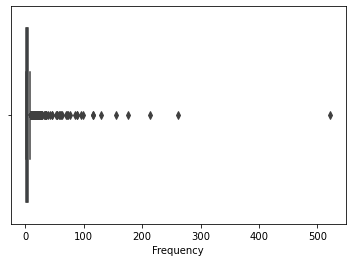

In [11]:
#Check Outlier on Frequency
display(sns.boxplot(lrfm['Frequency']))

In [12]:
# #delete outlier
# lrfm = lrfm[~(lrfm['Frequency'] > 57)]
# sns.boxplot(x=lrfm['Frequency'])

In [13]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column], kde=False)
    
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

def norm_minmax(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

Length's: Skew: 0.42393719034736754, : SkewtestResult(statistic=6.017996054132643, pvalue=1.7658949748527417e-09)
Recency's: Skew: 1.1345987300500122, : SkewtestResult(statistic=13.693803718844693, pvalue=1.1056633781363874e-42)
Frequency's: Skew: 14.690536673841917, : SkewtestResult(statistic=43.521629075089805, pvalue=0.0)
Monetary's: Skew: 9.772043517284278, : SkewtestResult(statistic=38.57094609139967, pvalue=0.0)


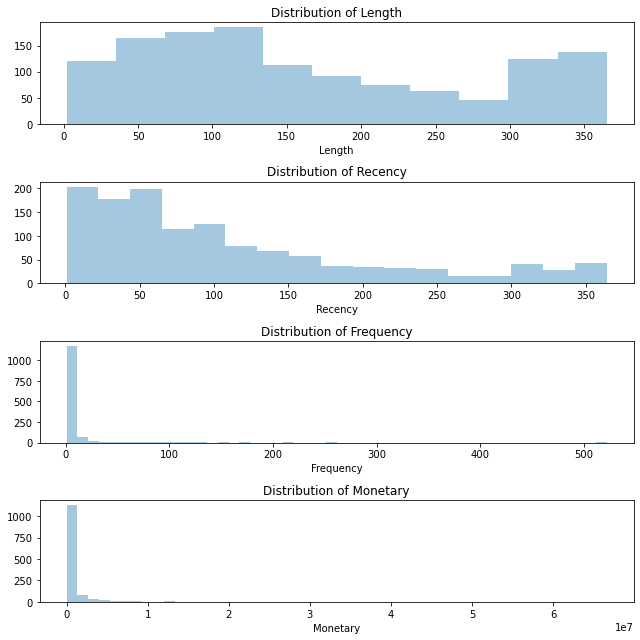

In [14]:
# Plot all 4 graphs to check skewness
plt.figure(figsize=(9, 9))

plt.subplot(4, 1, 1)
check_skew(lrfm,'Length')

plt.subplot(4, 1, 2)
check_skew(lrfm,'Recency')

plt.subplot(4, 1, 3)
check_skew(lrfm,'Frequency')

plt.subplot(4, 1, 4)
check_skew(lrfm,'Monetary')

plt.tight_layout()
plt.savefig('Grafik/before_transform.png', format='png', dpi=1000)

In [15]:
#Frequency dan monetary skewnya ndak masuk akal

## Transformation & Normalization

Length's: Skew: 0.42393719034736754, : SkewtestResult(statistic=6.017996054132643, pvalue=1.7658949748527417e-09)
Recency's: Skew: 0.36681335863818454, : SkewtestResult(statistic=5.256882607546363, pvalue=1.4651777192440396e-07)
Frequency's: Skew: 1.0471724433355378, : SkewtestResult(statistic=12.915075531650865, pvalue=3.7008073040811544e-38)
Monetary's: Skew: 0.8902792272064285, : SkewtestResult(statistic=11.412303075622109, pvalue=3.6298912702912806e-30)


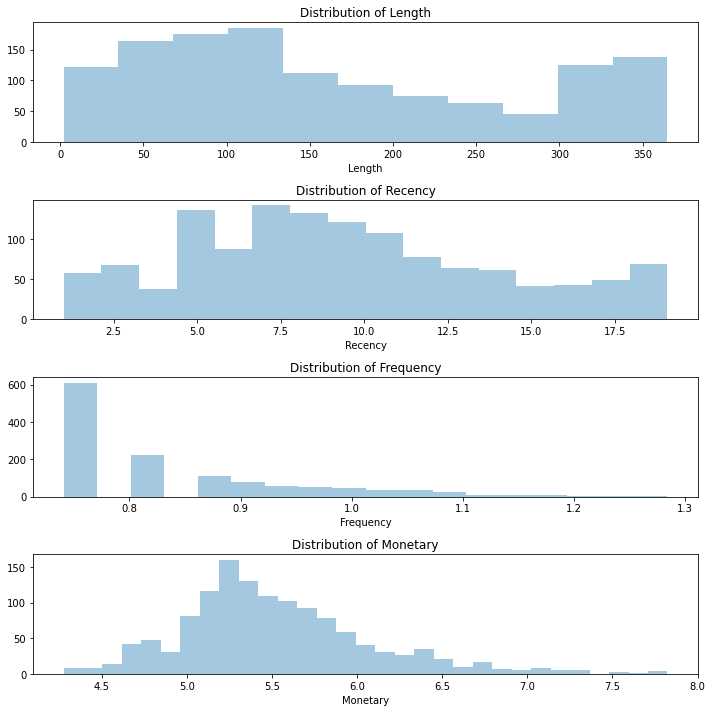

In [16]:
lrfm_trans = lrfm.copy()
#log10 Transformation
# lrfm_trans['Frequency'] = lrfm_trans['Frequency'].apply(lambda x: 1/x)
# lrfm_trans['Monetary'] = lrfm_trans['Monetary'].apply(lambda x: 1/x)

lrfm_trans['Recency'] = np.sqrt(lrfm_trans['Recency'])
lrfm_trans['Frequency'] = np.log10(lrfm_trans['Frequency']+1)
lrfm_trans['Monetary'] = np.log10(lrfm_trans['Monetary']+1)

lrfm_trans['Frequency'] = np.sqrt(lrfm_trans['Frequency'])

lrfm_trans['Frequency'] = np.sqrt(lrfm_trans['Frequency'])

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
check_skew(lrfm_trans,'Length')
plt.subplot(4, 1, 2)
check_skew(lrfm_trans,'Recency')
plt.subplot(4, 1, 3)
check_skew(lrfm_trans,'Frequency')
plt.subplot(4, 1, 4)
check_skew(lrfm_trans,'Monetary')

plt.tight_layout()
plt.savefig('Grafik/after_transform.png', format='png', dpi=1000)

In [17]:
#Min-Max Normalization
norm_lrfm = norm_minmax(lrfm_trans)

#Mengubah nilai Recency menggunakan 1-R karena merupakan kebalikan dari variabel lain
#R asli jika semakin kecil akan semakin bagus
norm_lrfm['Recency'] = 1-norm_lrfm['Recency']

norm_lrfm.describe()

,Length,Recency,Frequency,Monetary
count,1296.000000,1296.000000,1296.000000,1296.000000
mean,0.447053,0.541158,0.180363,0.351663
std,0.300124,0.255201,0.213021,0.157660
min,0.000000,0.000000,0.000000,0.000000
25%,0.206612,0.373363,0.000000,0.255262
50%,0.366391,0.571521,0.166362,0.325612
75%,0.702479,0.732783,0.319577,0.434749
max,1.000000,1.000000,1.000000,1.000000


# K-Means Clustering

In [18]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from yellowbrick.cluster import SilhouetteVisualizer
from kneed import KneeLocator

## Find K Optimum

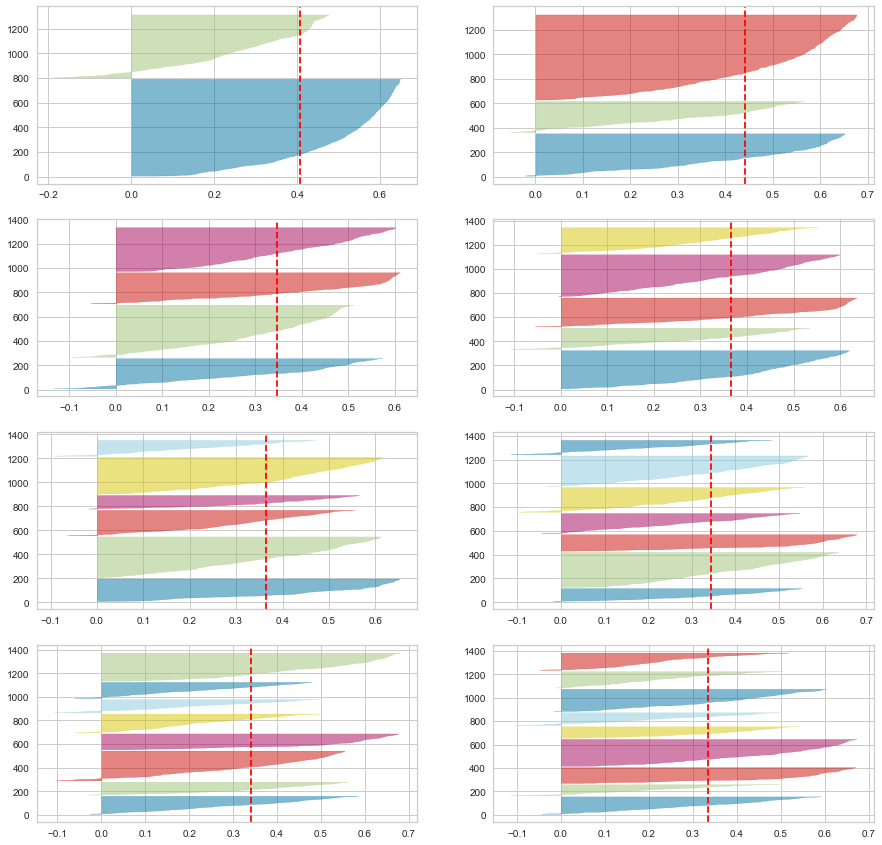

In [19]:
K = range(2,10)
fig, ax = plt.subplots(4, 2, figsize=(15,15))

# Silhouette Method metrics
euclidean = []
#Elbow Method metrics
inertias = [] 
ch_index = []
db_index = []
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=123)
    kmeanModel.fit(norm_lrfm)     
    
    # Silhouette Method metrics
    euclidean.append(silhouette_score(norm_lrfm, kmeanModel.labels_, metric='euclidean'))

    # Silhouette also
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(kmeanModel, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(norm_lrfm)

    #Elbow Method metrics
    inertias.append(kmeanModel.inertia_) 

    # C-H Index
    ch_index.append(calinski_harabasz_score(norm_lrfm,kmeanModel.labels_))

    # DB Index
    db_index.append(davies_bouldin_score(norm_lrfm,kmeanModel.labels_))


Highest Euclidean Value = 0.44028772052676296 at K=3


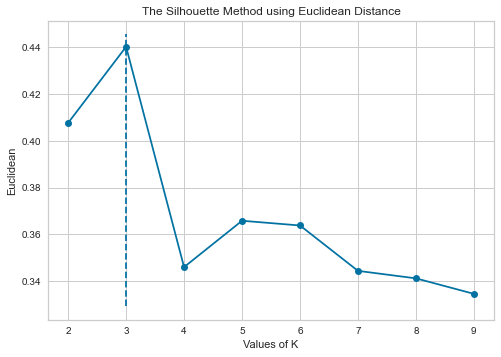

In [20]:
ymax = max(euclidean)
xpos = euclidean.index(ymax)
xmax = K[xpos]

print("Highest Euclidean Value = %s at K=%s" % (ymax, xmax,))
plt.plot(K, euclidean, 'bo-') 
plt.xlabel('Values of K') 
plt.ylabel('Euclidean') 
plt.title('The Silhouette Method using Euclidean Distance') 
plt.vlines(xmax, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Silhouette Method using Euclidean Distance.png', format='png', dpi=1000)
plt.show() 

Elbow at K = 4


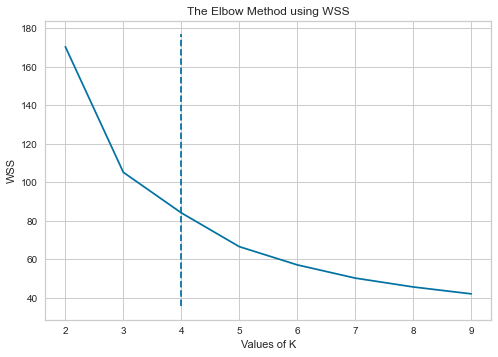

In [21]:
# Elbow method Viz
kn = KneeLocator(K, inertias, curve='convex', direction='decreasing')
print("Elbow at K =", kn.knee)

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('WSS') 
plt.title('The Elbow Method using WSS') 
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Elbow Method using Inertia.png', format='png', dpi=1000)
plt.show() 

In [22]:
ch_index

[923.955482287924,
 1147.5259363309806,
 1063.002429817647,
 1091.0967250747292,
 1059.056026584324,
 1031.3172100424251,
 990.5057320091673,
 953.1855352438072]

Highest CH-Index Value = 1147.5259363309806 at K=3


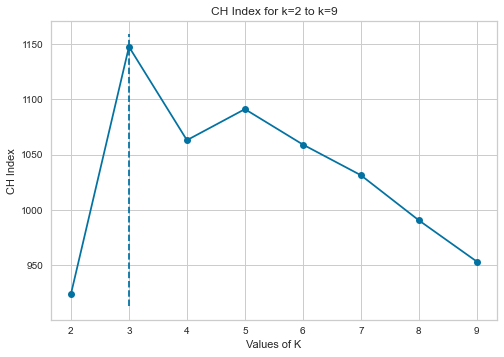

In [23]:
# CH Index Viz
ymax = max(ch_index)
xpos = ch_index.index(ymax)
xmax = K[xpos]

print("Highest CH-Index Value = %s at K=%s" % (ymax, xmax,))
plt.plot(K, ch_index, 'bo-') 
plt.xlabel('Values of K') 
plt.ylabel('CH Index') 
plt.title('CH Index for k=2 to k=9') 
plt.vlines(xmax, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/CH Index.png', format='png', dpi=1000)
plt.show() 

Lowest DB Index Value = 1147.5259363309806 at K=3


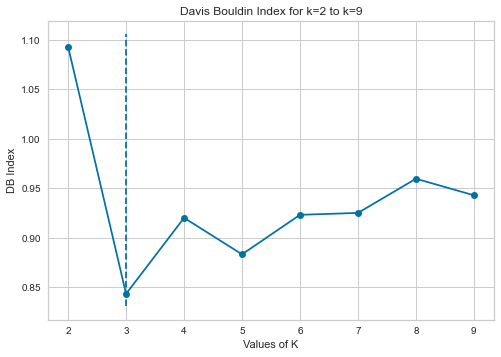

In [24]:
# DB Index Viz
ymin = min(db_index)
xpos = db_index.index(ymin)
xmax = K[xpos]

print("Lowest DB Index Value = %s at K=%s" % (ymax, xmax,))
plt.plot(K, db_index, 'bo-') 
plt.xlabel('Values of K') 
plt.ylabel('DB Index') 
plt.title('Davis Bouldin Index for k=2 to k=9') 
plt.vlines(xmax, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show() 

## Clustering!!

In [25]:
K_fix = 3

In [26]:
def kmeans(normalised_df_lrfm, clusters_number, original_df_lrfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 123)
    kmeans.fit(normalised_df_lrfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_lrfm.assign(Cluster = cluster_labels)
    df_new['Cluster'] += 1

    # # Initialise TSNE
    # model = TSNE(random_state=1)
    # transformed = model.fit_transform(df_new)
    
    # # Plot t-SNE
    # plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    # sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

def snake_plot(normalised_df_lrfm, df_lrfm_kmeans, df_lrfm_original):

    normalised_df_lrfm = pd.DataFrame(normalised_df_lrfm, 
                                       index=df_lrfm_original.index, 
                                       columns=df_lrfm_original.columns)
    normalised_df_lrfm['Cluster'] = df_lrfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_lrfm.reset_index(), 
                        id_vars=['telp', 'Cluster'],
                        value_vars=['Length', 'Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

def threeD_plot(df_merge):
    from mpl_toolkits.mplot3d import Axes3D
    
    x = np.array(df_merge['Recency_norm'])
    y = np.array(df_merge['Frequency_norm'])
    z = np.array(df_merge['Monetary_norm'])

    plt.xlabel('Recency')
    plt.ylabel('Frequency')
    # plt.zlabel('Monetary')
    
    ax.scatter(x,y,z, s=(df_merge['Length_norm']*40), marker="s", c=df_merge["Cluster"], cmap="rainbow")
    # scatter = ax.scatter(x, y, c=c, s=s) 
    # legend = ax.legend(*scatter.legend_elements(),
    #                 loc="lower left", title="Classes")
    # ax.add_artist(legend)
    # ax.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0)) 


    return


In [27]:
#Scatter Plot
# plt.figure(figsize=(16, 8))
df_cluster_fix = kmeans(norm_lrfm, K_fix, lrfm)

# plt.savefig('Grafik/Cluster_is_4-flattened.png', format='png', dpi=300)

In [28]:
df_lrfm_all = pd.merge(df_cluster_fix, norm_lrfm, on='telp', suffixes=('_real', '_norm'))

df_lrfm_all.to_csv("Hasil/Data_TA Clustered_LRFM.csv")
df_lrfm_all

,Length_real,Recency_real,Frequency_real,Monetary_real,Cluster,Length_norm,Recency_norm,Frequency_norm,Monetary_norm
telp,,,,,,,,,
628111699469,66,66,1,165500.0,3,0.176309,0.605945,0.000000,0.265681
628112501890,361,344,5,485000.0,1,0.988981,0.029402,0.365337,0.397332
628113002154,361,103,3,612600.0,1,0.988981,0.493943,0.257942,0.425931
628113020777,202,4,3,575000.0,2,0.550964,0.944687,0.257942,0.418175
62811304876,329,27,16,897300.0,2,0.900826,0.767896,0.575143,0.472667
...,...,...,...,...,...,...,...,...,...
628993360579,314,280,2,955000.0,1,0.859504,0.129742,0.166362,0.480298
628993464570,337,293,2,90000.0,1,0.922865,0.108500,0.166362,0.191091
628993883705,152,57,2,294100.0,3,0.413223,0.637706,0.166362,0.336081


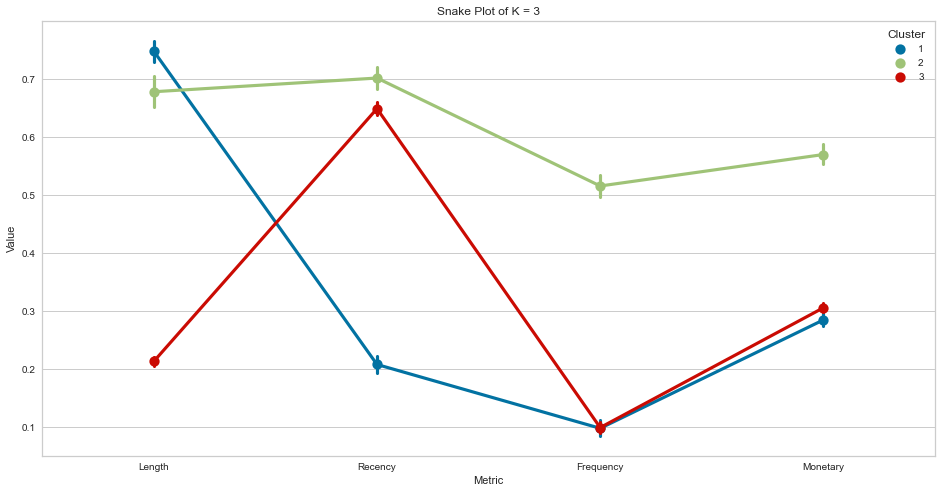

In [29]:
plt.figure(figsize=(16, 8))
#Snake Plot
plt.title("Snake Plot of K = %s" % (K_fix))
snake_plot(norm_lrfm, df_cluster_fix, lrfm)
plt.savefig('Grafik/Cluster_is_3-snakeplot.png', format='png', dpi=300)

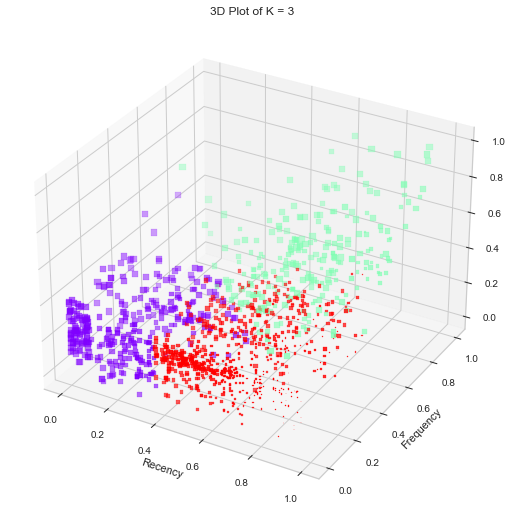

In [30]:
plt.figure(figsize=(16, 9))

#3D Plot
ax = plt.axes(projection='3d')
plt.title("3D Plot of K = %s" % (K_fix))
threeD_plot(df_lrfm_all)
plt.savefig('Grafik/Cluster_is_3-3dplot.png', format='png', dpi=300)

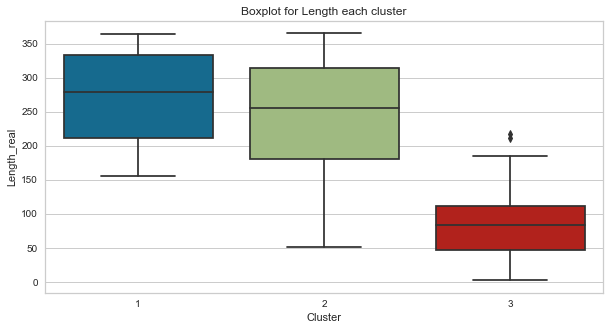

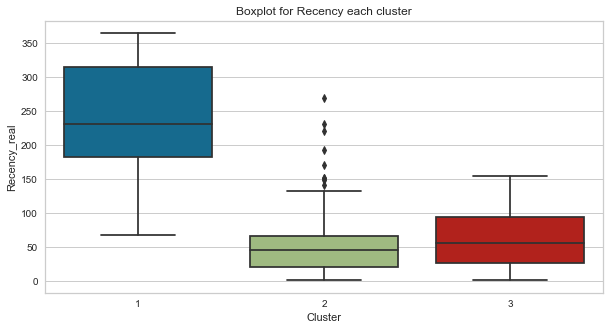

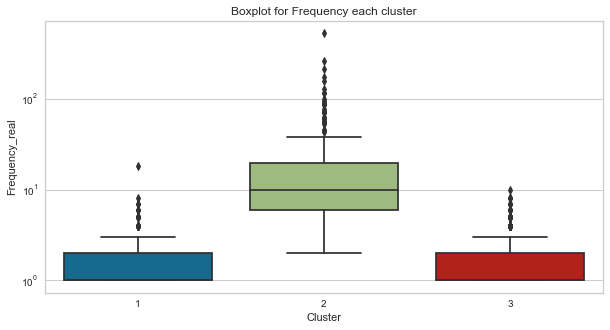

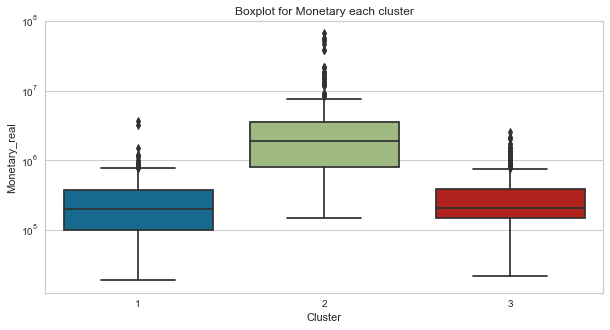

In [31]:
#BoxPlot for Real Data
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Length_real", data=df_lrfm_all)
plt.title('Boxplot for Length each cluster') 
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Recency_real", data=df_lrfm_all)
plt.title('Boxplot for Recency each cluster') 
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.yscale("log")
ax = sns.boxplot(x="Cluster", y="Frequency_real", data=df_lrfm_all)
plt.title('Boxplot for Frequency each cluster') 
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.yscale("log")
ax = sns.boxplot(x="Cluster", y="Monetary_real", data=df_lrfm_all)
plt.title('Boxplot for Monetary each cluster') 
plt.show()

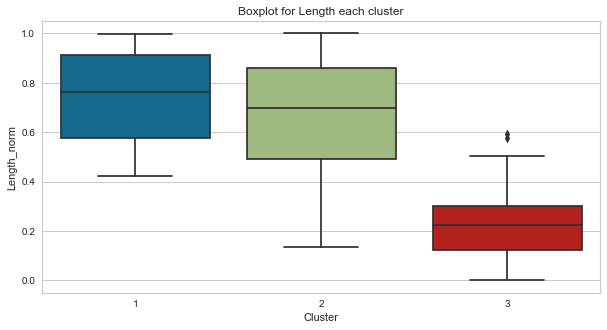

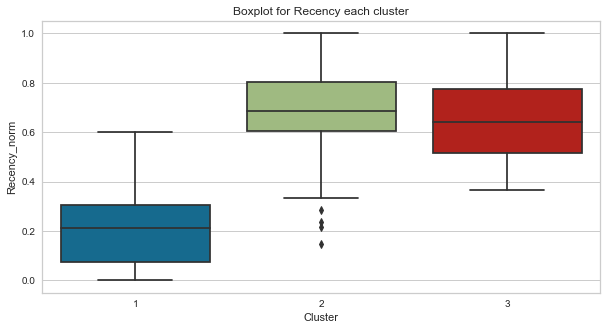

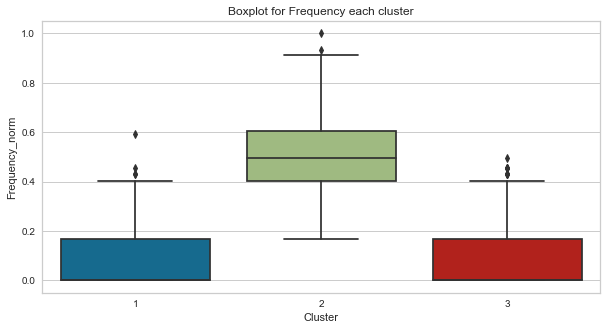

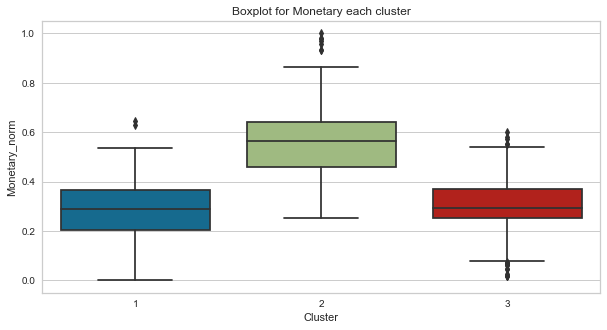

In [32]:
#Boxplot for Normalized data
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Length_norm", data=df_lrfm_all)
plt.title('Boxplot for Length each cluster') 
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Recency_norm", data=df_lrfm_all)
plt.title('Boxplot for Recency each cluster') 
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Frequency_norm", data=df_lrfm_all)
plt.title('Boxplot for Frequency each cluster') 
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Monetary_norm", data=df_lrfm_all)
plt.title('Boxplot for Monetary each cluster') 
plt.show()

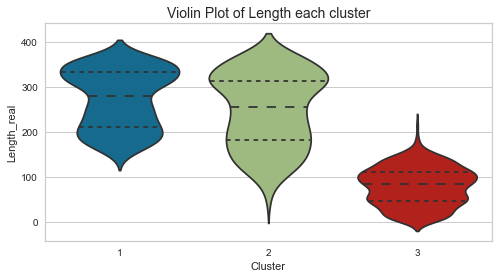

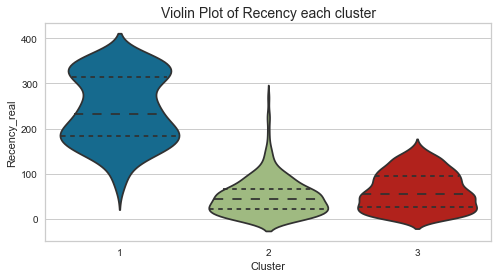

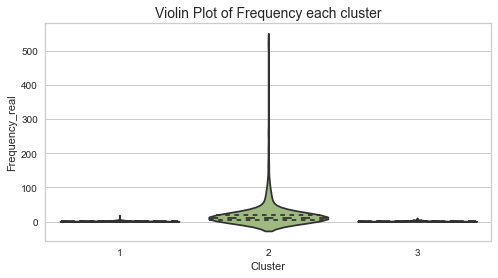

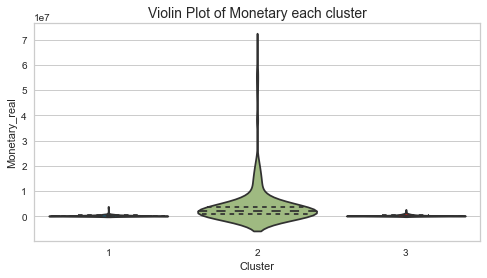

<Figure size 576x396 with 0 Axes>

In [33]:
#Violin Plot
plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Length_real', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Length each cluster', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Recency_real', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Recency each cluster', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Frequency_real', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Frequency each cluster', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Monetary_real', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Monetary each cluster', fontsize=14)
plt.show()

plt.savefig('Grafik/Cluster_is_3-Violin.png', format='png', dpi=300)

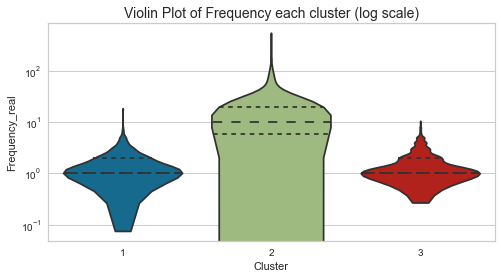

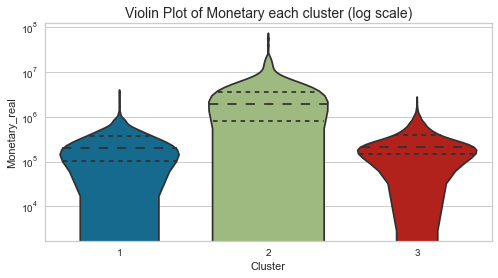

In [34]:
plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Frequency_real', data=df_lrfm_all, scale='width', inner='quartile')
plt.yscale("log")
plt.title('Violin Plot of Frequency each cluster (log scale)', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Monetary_real', data=df_lrfm_all, scale='width', inner='quartile')
plt.yscale("log")
plt.title('Violin Plot of Monetary each cluster (log scale)', fontsize=14)
plt.show()

In [ ]:
#Violin Plot
plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Length_norm', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Normalized Length each cluster', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Recency_norm', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Normalized Recency each cluster', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Frequency_norm', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Normalized Frequency each cluster', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Monetary_norm', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Normalized Monetary each cluster', fontsize=14)
plt.show()

plt.savefig('Grafik/Cluster_is_3-Violin_norm.png', format='png', dpi=300)

# Cluster Analysis

In [35]:
df_cluster_fix.reset_index().groupby(['Cluster']).agg({'telp':'count'})

,telp
Cluster,
1,346
2,255
3,695


In [ ]:
for i in range(1, K_fix+1) :
    #slice data
    print("LRFM Characteristics for cluster", i)
    df_cluster_fix[lambda x: x['Cluster'] == i].describe()

In [36]:
def lrfm_values(df):
    lrfm_cluster = df.groupby(['Cluster']).agg(['mean','median', 'min', 'max']).round(3)
    return lrfm_cluster

In [37]:
lrfm_values(df_cluster_fix)

Length                   Recency                 Frequency         \
            mean median  min  max     mean median min  max      mean median   
Cluster                                                                       
1        273.355  279.5  155  364  241.280  231.5  68  364     1.824      1   
2        247.988  256.0   51  365   49.635   45.0   1  269    22.145     10   
3         79.265   84.0    2  217   62.452   56.0   1  155     1.842      1   

                     Monetary                                   
        min  max         mean     median       min         max  
Cluster                                                         
1         1   18   290171.127   200000.0   18900.0   3716000.0  
2         2  522  4584608.780  1910750.0  148500.0  66570810.0  
3         1   10   322256.694   209500.0   22000.0   2574980.0

In [38]:
#mean from all dataframe
df_lrfm_all.mean(axis=0).round(3)

Length_real           164.280
Recency_real          107.673
Frequency_real          5.832
Monetary_real     1152347.879
Cluster                 2.269
Length_norm             0.447
Recency_norm            0.541
Frequency_norm          0.180
Monetary_norm           0.352
dtype: float64

## Menghitung CLV

In [39]:
#Nilai bobot didapatkan dari file excel
AHP = {
    'Length' : 0.055,
    'Recency' : 0.104,
    'Frequency' : 0.348,
    'Monetary' : 0.493}

count    1296.000000
mean        0.317005
std         0.162316
min         0.059001
25%         0.199005
50%         0.272134
75%         0.407364
max         0.972138
Name: CLV, dtype: float64

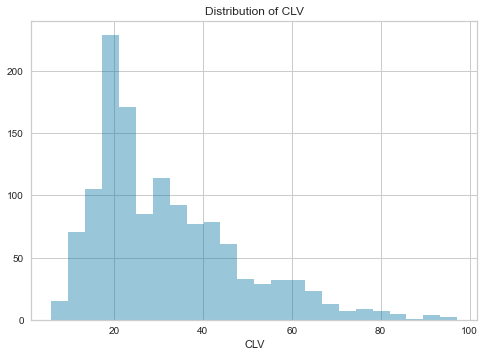

In [40]:
df_lrfm_all['CLV'] = (df_lrfm_all['Length_norm']*AHP['Length'] + df_lrfm_all['Recency_norm']*AHP['Recency'] + df_lrfm_all['Frequency_norm']*AHP['Frequency'] + df_lrfm_all['Monetary_norm']*AHP['Monetary'])
display(df_lrfm_all['CLV'].describe())

#Agar angka lebih cantik dan mudah dibaca, kita kalikan 1000
df_lrfm_all['CLV'] = df_lrfm_all['CLV']*100
plt.title('Distribution of CLV')
sns.distplot(df_lrfm_all['CLV'], kde=False)
plt.show()

## Rank CLV

In [41]:
def clv_values(df):
    clv_cluster = df.groupby(['Cluster']).agg({
        'Length_real': ['min', 'max', 'mean'],
        'Recency_real': ['min', 'max', 'mean'],
        'Frequency_real': ['min', 'max', 'mean'],
        'Monetary_real': ['min', 'max', 'mean'],
        'CLV' : ['min', 'max', 'mean', 'median']
    }).round(0)
    
    return clv_cluster

In [42]:
clv_values(df_lrfm_all).sort_values(by=[('CLV','mean')], ascending=False)

Length_real             Recency_real             Frequency_real       \
                min  max   mean          min  max   mean            min  max   
Cluster                                                                        
2                51  365  248.0            1  269   50.0              2  522   
3                 2  217   79.0            1  155   62.0              1   10   
1               155  364  273.0           68  364  241.0              1   18   

              Monetary_real                          CLV                     
         mean           min         max       mean   min   max  mean median  
Cluster                                                                      
2        22.0      148500.0  66570810.0  4584609.0  34.0  97.0  57.0   56.0  
3         2.0       22000.0   2574980.0   322257.0   8.0  56.0  26.0   23.0  
1         2.0       18900.0   3716000.0   290171.0   6.0  59.0  24.0   22.0

# Market Basket Analysis

In [43]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

## Join Dataframe

In [44]:
df_basket_all = pd.merge(df_clean, df_cluster_fix, on='telp', how='left')
df_basket_all = df_basket_all[['delivery_date', 'no_order', 'name', 'telp', 'produk', 'qty', 'Cluster']].copy()
df_basket_all.to_csv("Hasil/Data_TA Clustered_Transaksi.csv")

#drop NA from frequency outlier
df_basket_all.dropna(subset=['Cluster'], inplace=True)

print("Dataset dimension : " + str(df_basket_all.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df_basket_all['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df_basket_all['no_order']))))

Dataset dimension : (22083, 7)
Jumlah Customer : 1296
Jumlah Transaksi : 7558


In [45]:
#clean the product names
df_basket_all['produk'] = df_basket_all['produk'].str.strip()
df_basket_all['no_order'] = df_basket_all['no_order'].astype('str')

### Create basket datafarme from transactions data with each row representing one basket

In [46]:
#one hot encode the basket
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#create MBA for every cluster
def createMBA(basket_data) :
    totalTransactions = len(basket_data.index)
    totalCustomers = len(pd.unique(basket_data['telp']))
    minTransaction = totalTransactions*0.005
    min_support_calc = minTransaction/totalTransactions

    print('Jumlah Pelanggan = ', totalCustomers)
    print('Jumlah Transaksi yang dianalisis = ', totalTransactions)
    print('Nilai Support Minimum = ', round(min_support_calc*100, 4), '%')

    basket = basket_data.groupby(['no_order', 'produk'])['qty'].sum().unstack().reset_index().fillna(0).set_index('no_order')
    basket_sets = basket.applymap(encode_units)
    basket_sets.dropna(inplace=True)
    basket_sets = basket_sets.astype(int)
    # display(basket_sets.head(5))

    #create frequent items sets with clculated minimum support
    frequent_itemsets = fpgrowth(basket_sets, min_support=min_support_calc, use_colnames=True)
    # display(frequent_itemsets.describe())

    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
    rules.sort_values('support', ascending = False, inplace = True)

    createMBA.rules = rules
    
    return rules

In [48]:
#MBA w/ Clustering
for i in range(1, K_fix+1) :
    #slice data
    print("Market Basket Analysis for Cluster", i)
    basket_data = df_basket_all[lambda x: x['Cluster'] == i]

    createMBA(basket_data)
    print('rules berhasil dibangkitkan = ', len(createMBA.rules.index))

    display(createMBA.rules.head(10))
    createMBA.rules.to_csv("Hasil/Data_TA FPGrowth_Cluster_%s.csv" % (i,), 'a')
    # rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_csv("Data/Ternakmart_Results_FPGrowth_Cluster_%s.csv" % (i,), 'a', newline='')
    print("\n \n")

Market Basket Analysis for Cluster 1
Jumlah Pelanggan =  346
Jumlah Transaksi yang dianalisis =  1472
Nilai Support Minimum =  0.5 %
rules berhasil dibangkitkan =  206


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA STROBERI 1L),0.074485,0.074485,0.044374,0.595745,7.998189,0.038826,2.289432
12,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA COKLAT 1L),0.074485,0.074485,0.044374,0.595745,7.998189,0.038826,2.289432
66,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA STROBERI 1L),0.060222,0.074485,0.036450,0.605263,8.125980,0.031964,2.344638
67,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA MELON 1L),0.074485,0.060222,0.036450,0.489362,8.125980,0.031964,1.840399
64,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA COKLAT 1L),0.060222,0.074485,0.034865,0.578947,7.772676,0.030380,2.198098
65,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA MELON 1L),0.074485,0.060222,0.034865,0.468085,7.772676,0.030380,1.766783
71,(JABMILK SUSU RASA MELON 1L),"(JABMILK SUSU RASA STROBERI 1L, JABMILK SUSU R...",0.060222,0.044374,0.028526,0.473684,10.674812,0.025854,1.815689
73,(JABMILK SUSU RASA COKLAT 1L),"(JABMILK SUSU RASA MELON 1L, JABMILK SUSU RASA...",0.074485,0.036450,0.028526,0.382979,10.506938,0.025811,1.561615
72,(JABMILK SUSU RASA STROBERI 1L),"(JABMILK SUSU RASA MELON 1L, JABMILK SUSU RASA...",0.074485,0.034865,0.028526,0.382979,10.984526,0.025929,1.564184
70,"(JABMILK SUSU RASA STROBERI 1L, JABMILK SUSU R...",(JABMILK SUSU RASA MELON 1L),0.044374,0.060222,0.028526,0.642857,10.674812,0.025854,2.631379



 

Market Basket Analysis for Cluster 2
Jumlah Pelanggan =  255
Jumlah Transaksi yang dianalisis =  16646
Nilai Support Minimum =  0.5 %
rules berhasil dibangkitkan =  98


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
42,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.079078,0.072872,0.020035,0.253363,3.476809,0.014273,1.241739
43,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.072872,0.079078,0.020035,0.274939,3.476809,0.014273,1.270131
10,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA COKLAT 1L),0.030674,0.041667,0.015426,0.502890,12.069364,0.014147,1.927810
11,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA STROBERI 1L),0.041667,0.030674,0.015426,0.370213,12.069364,0.014147,1.539133
22,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA COKLAT 1L),0.030319,0.041667,0.015248,0.502924,12.070175,0.013985,1.927941
23,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA MELON 1L),0.041667,0.030319,0.015248,0.365957,12.070175,0.013985,1.529362
6,(JABMILK SUSU RASA ORIGINAL 1L),(JABMILK SUSU RASA COKLAT 1L),0.033333,0.041667,0.015071,0.452128,10.851064,0.013682,1.749191
7,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA ORIGINAL 1L),0.041667,0.033333,0.015071,0.361702,10.851064,0.013682,1.514444
19,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA MELON 1L),0.030674,0.030319,0.012234,0.398844,13.154852,0.011304,1.613027
18,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA STROBERI 1L),0.030319,0.030674,0.012234,0.403509,13.154852,0.011304,1.625047



 

Market Basket Analysis for Cluster 3
Jumlah Pelanggan =  695
Jumlah Transaksi yang dianalisis =  3965
Nilai Support Minimum =  0.5 %
rules berhasil dibangkitkan =  50


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
16,(BUAH PEAR RRC SWEET ONS),(BUAH APEL FUJI PREMIUM RRC ONS),0.028346,0.051181,0.010236,0.361111,7.055556,0.008785,1.485108
41,(PROMO (DORI FILLET 500GR)),(JSM (BELI 1 GRATIS 1SOSIS SAPI ABBYS 200GR)),0.025197,0.024409,0.010236,0.406250,16.643145,0.009621,1.643100
40,(JSM (BELI 1 GRATIS 1SOSIS SAPI ABBYS 200GR)),(PROMO (DORI FILLET 500GR)),0.024409,0.025197,0.010236,0.419355,16.643145,0.009621,1.678828
6,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.045669,0.047244,0.010236,0.224138,4.744253,0.008079,1.227997
7,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.047244,0.045669,0.010236,0.216667,4.744253,0.008079,1.218295
17,(BUAH APEL FUJI PREMIUM RRC ONS),(BUAH PEAR RRC SWEET ONS),0.051181,0.028346,0.010236,0.200000,7.055556,0.008785,1.214567
32,(BUAH APEL FUJI PREMIUM RRC ONS),(BUAH PEAR YALIE ONS),0.051181,0.018110,0.008661,0.169231,9.344482,0.007735,1.181904
33,(BUAH PEAR YALIE ONS),(BUAH APEL FUJI PREMIUM RRC ONS),0.018110,0.051181,0.008661,0.478261,9.344482,0.007735,1.818570
19,(PROMO (DORI FILLET 500GR)),(JSM (BUAH APEL FUJI ONS)),0.025197,0.022047,0.008661,0.343750,15.591518,0.008106,1.490214
18,(JSM (BUAH APEL FUJI ONS)),(PROMO (DORI FILLET 500GR)),0.022047,0.025197,0.008661,0.392857,15.591518,0.008106,1.605558


In [49]:
#MBA w/o Clustering
createMBA(df_basket_all)
print('rules berhasil dibangkitkan = ', len(createMBA.rules.index))

display(createMBA.rules.head(10))
# createMBA.rules.to_csv("Hasil/Data_TA FPGrowth_Cluster_%s.csv" % (i,), 'a')
# rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_csv("Data/Ternakmart_Results_FPGrowth_Cluster_All.csv", 'a', newline='')
print("\n \n")

Jumlah Pelanggan =  1296
Jumlah Transaksi yang dianalisis =  22083
Nilai Support Minimum =  0.5 %
rules berhasil dibangkitkan =  84


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
40,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.067763,0.073995,0.017902,0.264188,3.570324,0.012888,1.258480
41,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.073995,0.067763,0.017902,0.241935,3.570324,0.012888,1.229760
4,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA COKLAT 1L),0.031428,0.039783,0.016178,0.514768,12.939550,0.014928,1.978883
5,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA STROBERI 1L),0.039783,0.031428,0.016178,0.406667,12.939550,0.014928,1.632424
21,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA MELON 1L),0.039783,0.029704,0.015250,0.383333,12.904985,0.014068,1.573453
20,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA COKLAT 1L),0.029704,0.039783,0.015250,0.513393,12.904985,0.014068,1.973291
8,(JABMILK SUSU RASA ORIGINAL 1L),(JABMILK SUSU RASA COKLAT 1L),0.030367,0.039783,0.014056,0.462882,11.635313,0.012848,1.787722
9,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA ORIGINAL 1L),0.039783,0.030367,0.014056,0.353333,11.635313,0.012848,1.499432
17,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA MELON 1L),0.031428,0.029704,0.012863,0.409283,13.778575,0.011929,1.642572
16,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA STROBERI 1L),0.029704,0.031428,0.012863,0.433036,13.778575,0.011929,1.708347


In [50]:
#MBA w/o Jabmilk
jabmilk = ['Jabmilk','Jab Milk']
df_nonjabmilk = df_clean[~df_clean['produk'].str.contains('|'.join(donasi))]

df_basket_nonjabmilk = pd.merge(df_nonjabmilk, df_cluster_fix, on='telp', how='left')
df_basket_nonjabmilk = df_basket_all[['delivery_date', 'no_order', 'name', 'telp', 'produk', 'qty', 'Cluster']].copy()

df_basket_nonjabmilk.dropna(subset=['Cluster'], inplace=True)
df_basket_nonjabmilk['produk'] = df_basket_all['produk'].str.strip()
df_basket_nonjabmilk['no_order'] = df_basket_all['no_order'].astype('str')

for i in range(1, K_fix+1) :
    #slice data
    print("Market Basket Analysis (Without Jabmilk) for Cluster", i)
    basket_data = df_basket_nonjabmilk[lambda x: x['Cluster'] == i]

    createMBA(basket_data)
    print('rules berhasil dibangkitkan = ', len(createMBA.rules.index))

    display(createMBA.rules.head(10))
    # createMBA.rules.to_csv("Hasil/Data_TA_nonjabmilk FPGrowth_Cluster_%s.csv" % (i,), 'a')
    # rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_csv("Data/Ternakmart_Results_nonjabmilk_FPGrowth_Cluster_%s.csv" % (i,), 'a', newline='')
    print("\n \n")